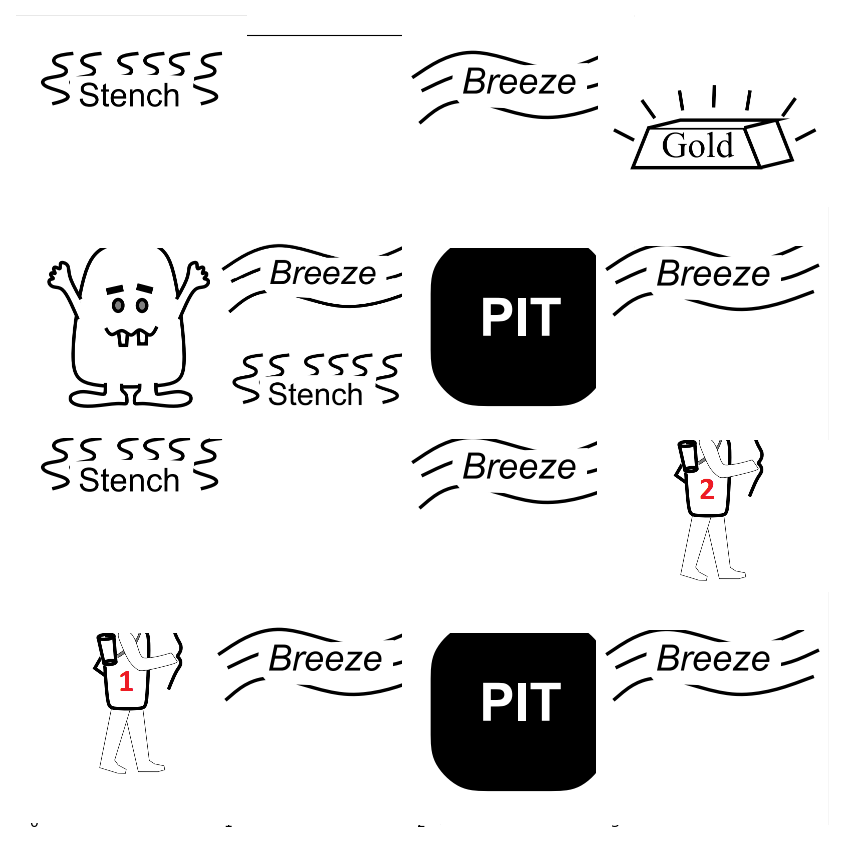

In [2]:
# Imports
import cv2
import gym
from gym import spaces
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from operator import add
import random

# This ensures that all the data isn't loaded into the GPU memory at once.
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# Disables eager execution.
tf.compat.v1.disable_eager_execution()


# Defining the Multi-Agent Wumpus World Environment.
class MultiAgentWumpusWorldEnvironment(gym.Env):
    """This class implements the Wumpus World environment."""

    def __init__(self, environment_type):
        """This method initializes the environment.

        :param environment_type: - (It can take two values: 1. 'deterministic' 2. 'stochastic' indicating the type of
                                    environment.)"""

        self.environment_type = environment_type  # This indicates whether the environment is of the type deterministic
                                                  # or stochastic.
        self.observation_space = spaces.Discrete(16)  # This defines that there are 16 states in the environment.
        self.action_space = spaces.Discrete(6)  # This defines that there are 6 discrete actions that the agent can
                                                # perform.
        self.number_of_agents = 2  # This defines the number of agents in the environment.
        self.number_of_arrows = 10  # This defines the number of arrows each agent has.
        self.arrows = [self.number_of_arrows for _ in range(self.number_of_agents)]  # List indicating the number of
                                                                                     # arrows per agent.
        self.agent_positions = [[0, 0], [3, 1]]  # Initializing the agents in fixed positions.
        self.breeze_pos = [[1, 0], [1, 2], [2, 1], [2, 3], [3, 0], [3, 2]]  # This defines the positions of breeze
                                                                            # in the environment.
        self.gold_pos = [3, 3]  # This defines the position of gold in the environment.
        self.gold_quantity = 1  # This defines the quantity of gold.
        self.pit_pos = [[2, 0], [2, 2]]  # This defines the positions of pit in the environment.
        self.stench_pos = [[0, 1], [0, 3], [1, 2]]  # This defines the positions of stench in the environment.
        self.wumpus_pos = [0, 2]  # This defines the position of the Wumpus in the environment.
        self.wumpus_alive = True  # Boolean indicating whether the Wumpus is alive or dead.
        self.timesteps = 0  # This defines the steps the agent has taken during an episode.
        self.max_timesteps = 10  # This defines the maximum steps the agent can take during an episode.
        # This defines the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                              for i in range(self.number_of_agents)]
        # This defines the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                                for i in range(self.number_of_agents)]

    def reset(self, random_start=False):
        """This method resets the agent position and returns the state as the observation.

        :param random_start: - (Boolean indicating whether the agent will start in a random or fixed position.)

        :returns observation: - (Integers from 0 to 15 defining the agent's position in the environment."""

        # Creating the mapping from the possible states the agent can start in to the co-ordinates.
        coordinates_state_mapping = {12: [0, 3], 13: [1, 3], 14: [2, 3],
                                     9: [1, 2], 11: [3, 2],
                                     4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
                                     0: [0, 0], 1: [1, 0], 3: [3, 0]}

        if not random_start:
            self.agent_positions = [[0, 0], [3, 1]]
            observation = [0, 7]
            # The state mapping for position [0, 0] is '0', and for position [3, 1] is '7'.

        else:
            # Randomly selecting the agent's position.
            observation = [random.choice([0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14]) for
                           _ in range(self.number_of_agents)]

            self.agent_positions = [coordinates_state_mapping[observation[i]] for i in range(self.number_of_agents)]

        self.arrows = [self.number_of_arrows for _ in range(self.number_of_agents)]  # Resetting the number of arrows.
        self.wumpus_alive = True  # Resetting the Wumpus to be alive.
        self.gold_quantity = 1  # Resetting the Gold quantity to be 1.
        self.timesteps = 0  # Resetting the number of steps taken by the agent.
        # Resetting the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                              for i in range(self.number_of_agents)]
        # Resetting the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                                for i in range(self.number_of_agents)]

        return observation

    def step(self, actions):
        """This function implements what happens when the agent takes a particular action. It changes the agent's
        position (While not allowing it to go out of the environment space.), maps the environment co-ordinates to a
        state, defines the rewards for the various states, and determines when the episode ends.

        :param actions: - (Vector of Integers in the range 0 to 5 inclusive.)

        :returns observation: - (Vector of Integers from 0 to 15 defining the agent's position in the environment.)
                 rewards: - (Vector of Integers values that are used to measure the performance of the agents.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        if self.environment_type == 'deterministic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    if self.arrows[i] > 0:
                        self.arrows[i] -= 1

        if self.environment_type == 'stochastic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        if self.arrows[i] > 0:
                            self.arrows[i] -= 1

        # Ensuring that the agent doesn't go out of the environment.
        self.agent_positions = np.clip(self.agent_positions, a_min=0, a_max=3)

        # Computing the new distance of the agents to the Gold.
        new_gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                             for i in range(self.number_of_agents)]

        # Setting the rewards to 0.
        rewards = [0 for _ in range(self.number_of_agents)]

        # Giving the agents reward 10 for picking up the Gold.
        for i in range(self.number_of_agents):
            if (self.agent_positions[i] == self.gold_pos).all():
                if self.gold_quantity > 0:
                    self.gold_quantity -= 1
                    rewards[i] = 10

        # Giving the agents different rewards if their distance to the Gold increases, decreases or remains the same.
        if self.gold_quantity > 0:
            for i in range(self.number_of_agents):
                # If agent moves away from the Gold it gets reward -1.
                if new_gold_distance[i] > self.gold_distance[i]:
                    rewards[i] = -1
                    self.gold_distance[i] = new_gold_distance[i]

                # If agent moves closer to the Gold it gets reward 1.
                elif new_gold_distance[i] < self.gold_distance[i]:
                    rewards[i] = 1
                    self.gold_distance[i] = new_gold_distance[i]

                else:  # If agent's distance to the Gold doesn't change it gets reward 0.
                    rewards[i] = 0

        # Computing the new distance of the agents to the Wumpus.
        new_wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                               for i in range(self.number_of_agents)]

        # Giving the agents different rewards if their distance to the Wumpus increases, decreases or remains the same.
        # These reward will only come in when the Gold is collected.
        if self.gold_quantity == 0:
            # If agent moves away from the Wumpus it gets reward -1.
            for i in range(self.number_of_agents):
                if new_wumpus_distance[i] > self.wumpus_distance[i]:
                    rewards[i] = -1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                # If agent moves closer to the Wumpus it gets reward 1.
                elif new_wumpus_distance[i] < self.wumpus_distance[i]:
                    rewards[i] = 1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                else:  # If the agent's distance to the Wumpus doesn't change it gets reward 0.
                    rewards[i] = 0

        # Creating the mapping from the co-ordinates to the state.
        coordinates_state_mapping = {'[0 3]': 12, '[1 3]': 13, '[2 3]': 14, '[3 3]': 15,
                                     '[0 2]': 8, '[1 2]': 9, '[2 2]': 10, '[3 2]': 11,
                                     '[0 1]': 4, '[1 1]': 5, '[2 1]': 6, '[3 1]': 7,
                                     '[0 0]': 0, '[1 0]': 1, '[2 0]': 2, '[3 0]': 3}

        # Setting the observation to be the state occupied by the agent.
        observation = [coordinates_state_mapping[f'{self.agent_positions[i]}'] for i in range(self.number_of_agents)]

        self.timesteps += 1  # Increasing the total number of steps taken by the agent.

        # Setting the reward to -1 if the agent falls into the pit.
        for i in range(self.number_of_agents):
            for j in range(len(self.pit_pos)):
                if (self.agent_positions[i] == self.pit_pos[j]).all():
                    rewards[i] = -1

            # Setting the reward to -1 if the agent is killed by the Wumpus.
            if (self.agent_positions[i] == self.wumpus_pos).all():
                rewards[i] = -1

        # Giving the agents reward 10 for killing the Wumpus.
        if all((self.wumpus_distance[i] == 1 and actions[i] == 5 and self.arrows[i] > 0)
               for i in range(self.number_of_agents)):
            rewards = [10 for _ in range(self.number_of_agents)]
            self.wumpus_alive = False

        # The episode terminates when one agent picks the Gold and both agents kill the Wumpus together,
        # or at least one agent is killed by the Wumpus, falls into the pit, or takes more than 10 steps.
        if (self.gold_quantity == 0 and not self.wumpus_alive) or \
                any((self.agent_positions[i] == self.wumpus_pos).all() for i in range(self.number_of_agents)):
            done = True
        else:
            done = False
        for i in range(len(self.pit_pos)):
            if any((self.agent_positions[i] == self.pit_pos[i]).all() for i in range(self.number_of_agents)):
                done = True
        if self.timesteps == self.max_timesteps:
            done = True
        info = {}

        return observation, rewards, done, info

    @staticmethod
    def compute_distance(x, y):
        """This method computes the distance between the old and new.

        :param x: This is the first array representing the agent position.
        :param y: This is the second array representing the goal position.

        :returns distance: The Manhattan distance between the agent and the goal."""

        distance = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return distance

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param mode:
        :param plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(10, 10))  # Initializing the figure.
        ax.set_xlim(0, 4)  # Setting the limit on the x-axis.
        ax.set_ylim(0, 4)  # Setting the limit on the y-axis.

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus = \
                False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if plot_pos[0] == self.agent_positions[0][0] and plot_pos[1] == self.agent_positions[0][1]:
                plot_agent_1 = True
            if plot_pos[0] == self.agent_positions[1][0] and plot_pos[1] == self.agent_positions[1][1]:
                plot_agent_2 = True
            for i in range(len(self.breeze_pos)):
                if plot_pos == self.breeze_pos[i]:
                    plot_breeze = True
            if self.gold_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if plot_pos == self.gold_pos:
                    plot_gold = True
            for i in range(len(self.pit_pos)):
                if plot_pos == self.pit_pos[i]:
                    plot_pit = True
            for i in range(len(self.stench_pos)):
                if plot_pos == self.stench_pos[i]:
                    plot_stench = True
            if plot_pos == self.wumpus_pos:
                plot_wumpus = True

            # Plot for Agent 1.
            if plot_agent_1 and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1.png'), zoom=0.36),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1)

            # Plot for Agent 2.
            if plot_agent_2 and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2.png'), zoom=0.36),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2)

            # Plot for Breeze.
            if plot_breeze and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/breeze.png'), zoom=0.36),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze)

            # Plot for Gold.
            if plot_gold and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_stench, plot_wumpus]):
                gold = AnnotationBbox(OffsetImage(plt.imread('./images/gold.png'), zoom=0.36),
                                      list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(gold)

            # Plot for Pit.
            if plot_pit and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/pit.png'), zoom=0.36),
                                     list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(pit)

            # Plot for Stench.
            if plot_stench and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                stench = AnnotationBbox(OffsetImage(plt.imread('./images/stench.png'), zoom=0.36),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench)

            # Plot for alive Wumpus.
            if self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_alive = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_alive)

            # Plot for dead Wumpus.
            if not self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_dead = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus_dead.png'), zoom=0.36),
                                                 list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_dead)

            # Plot for Agent 1 and Agent 2.
            if all(item for item in [plot_agent_1, plot_agent_2]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2.png'), zoom=0.36),
                                           list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2)

            # Plot for Agent 1 and Breeze.
            if all(item for item in [plot_agent_1, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_breeze)

            # Plot for Agent 2 and Breeze.
            if all(item for item in [plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_breeze)

            # Plot for Agent 1, Agent 2, and Breeze.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_breeze)

            # Plot for Agent 1 and Pit.
            if all(item for item in [plot_agent_1, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_dead_pit.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_pit)

            # Plot for Agent 2 and Pit.
            if all(item for item in [plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_dead_pit.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_pit)

            # Plot for Agent 1, Agent 2, and Pit.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_dead_pit.png'), zoom=0.36),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_pit)

            # Plot for Agent 1 and Stench.
            if all(item for item in [plot_agent_1, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_stench.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_stench)

            # Plot for Agent 2 and Stench.
            if all(item for item in [plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_stench.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_stench)

            # Plot for Agent 1, Agent 2, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_stench.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_stench)

            # Plot for Agent 1, Breeze, Stench.
            if all(item for item in [plot_agent_1, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                agent_1_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze_stench.png'),
                                                                   zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_1_breeze_stench)

            # Plot for Agent 2, Breeze, Stench.
            if all(item for item in [plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_wumpus]):
                agent_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze_stench.png'),
                                                                   zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_2_breeze_stench)

            # Plot for Agent 1, Agent 2, Breeze, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze_stench.png'),
                                                                     zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                         frameon=False)
                ax.add_artist(agent_1_2_breeze_stench)

            # Plot for Breeze and Gold.
            if all(item for item in [plot_breeze, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_stench, plot_wumpus]):
                breeze_gold = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold)

            # Plot for Breeze and Stench.
            if all(item for item in [plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_stench.png'), zoom=0.36),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_stench)

            # Plot for Breeze, Stench, and Gold.
            if all(item for item in [plot_breeze, plot_gold, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_wumpus]):
                breeze_gold_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold_stench.png'),
                                                    zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold_stench)

            # Plot for Stench and Gold.
            if all(item for item in [plot_stench, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_wumpus]):
                stench_gold = AnnotationBbox(OffsetImage(plt.imread('./images/stench_gold.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench_gold)

        # Dictionary mapping the states to their co-ordinates.
        coordinates_state_mapping = {
            12: [0, 3], 13: [1, 3], 14: [2, 3], 15: [3, 3],
            8: [0, 2], 9: [1, 2], 10: [2, 2], 11: [3, 2],
            4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
            0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [3, 0]}

        # Rendering the images for all states.
        for state in range(self.observation_space.n):
            plot_image(coordinates_state_mapping[state])

        plt.xticks([0, 1, 2, 3])  # Specifying the ticks on the x-axis.
        plt.yticks([0, 1, 2, 3])  # Specifying the ticks on the y-axis.
        plt.grid()  # Setting the plot to be of the type 'grid'.

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :1]
            width = int(img.shape[1] * 84 / 1000)
            height = int(img.shape[0] * 84 / 1000)
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            return preprocessed_image

wumpus_world = MultiAgentWumpusWorldEnvironment(environment_type='deterministic')
wumpus_world.reset()
wumpus_world.render(plot=True)

In [12]:
# Imports
import cv2
import gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from operator import add
import random


# Defining the Multi-Agent Wumpus World Environment.
class MultiAgentWumpusWorldEnvironment(gym.Env):
    """This class implements the Wumpus World environment."""

    def __init__(self, environment_type):

        self.environment_type = environment_type  
                                                  
        self.observation_space = spaces.Discrete(16)  
        self.action_space = spaces.Discrete(6)  
                                                
        self.number_of_agents = 2  
        self.number_of_arrows = 10 
        self.arrows = self.number_of_arrows  
                                                                                    
        self.agent_position = [0, 0]  
        self.breeze_pos = [[1, 0], [1, 2], [2, 1], [2, 3], [3, 0], [3, 2]]  
                                                                          
        self.gold_pos = [3, 3]  
        self.gold_quantity = 1  
        self.pit_pos = [[2, 0], [2, 2]]  
        self.stench_pos = [[0, 1], [0, 3], [1, 2]]
        self.wumpus_pos = [3, 1]  
        self.wumpus_alive = True  
        self.timesteps = 0  
        self.max_timesteps = 10  
        # This defines the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_position, self.gold_pos)]
        # This defines the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_position, self.wumpus_pos)]

    def reset(self, random_start=False):

        # Creating the mapping from the possible states the agent can start in to the co-ordinates.
        coordinates_state_mapping = {12: [0, 3], 13: [1, 3], 14: [2, 3],
                                     9: [1, 2], 11: [3, 2],
                                     4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
                                     0: [0, 0], 1: [1, 0], 3: [3, 0]}

        if not random_start:
            self.agent_position = [0, 0]
            self.wumpus_pos = [3,1]
            observation = [0, 7]
           

        else:
            # Randomly selecting the agent's position.
            observation = [random.choice([0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14]) for
                           _ in range(self.number_of_agents)]
            print(observation)

            self.agent_position = [coordinates_state_mapping[observation[0]]]
            print(self.agent_position)
            self.wumpus_pos = [coordinates_state_mapping[observation[1]]]
            print(self.wumpus_pos)
        self.arrows = [self.number_of_arrows for _ in range(self.number_of_agents)]  
        self.wumpus_alive = True  
        self.gold_quantity = 1  
        self.timesteps = 0  
        # Resetting the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_position, self.gold_pos)]
        # Resetting the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_position, self.wumpus_pos)]

        return observation

    def step(self, actions):
        """This function implements what happens when the agent takes a particular action. It changes the agent's
        position (While not allowing it to go out of the environment space.), maps the environment co-ordinates to a
        state, defines the rewards for the various states, and determines when the episode ends.

        :param actions: - (Vector of Integers in the range 0 to 5 inclusive.)

        :returns observation: - (Vector of Integers from 0 to 15 defining the agent's position in the environment.)
                 rewards: - (Vector of Integers values that are used to measure the performance of the agents.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        if self.environment_type == 'deterministic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    if self.arrows[i] > 0:
                        self.arrows[i] -= 1

        if self.environment_type == 'stochastic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        if self.arrows[i] > 0:
                            self.arrows[i] -= 1

        # Ensuring that the agent doesn't go out of the environment.
        self.agent_positions = np.clip(self.agent_positions, a_min=0, a_max=3)

        # Computing the new distance of the agents to the Gold.
        new_gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                             for i in range(self.number_of_agents)]

        # Setting the rewards to 0.
        rewards = [0 for _ in range(self.number_of_agents)]

        # Giving the agents reward 10 for picking up the Gold.
        for i in range(self.number_of_agents):
            if (self.agent_positions[i] == self.gold_pos).all():
                if self.gold_quantity > 0:
                    self.gold_quantity -= 1
                    rewards[i] = 10

        # Giving the agents different rewards if their distance to the Gold increases, decreases or remains the same.
        if self.gold_quantity > 0:
            for i in range(self.number_of_agents):
                # If agent moves away from the Gold it gets reward -1.
                if new_gold_distance[i] > self.gold_distance[i]:
                    rewards[i] = -1
                    self.gold_distance[i] = new_gold_distance[i]

                # If agent moves closer to the Gold it gets reward 1.
                elif new_gold_distance[i] < self.gold_distance[i]:
                    rewards[i] = 1
                    self.gold_distance[i] = new_gold_distance[i]

                else:  # If agent's distance to the Gold doesn't change it gets reward 0.
                    rewards[i] = 0

        # Computing the new distance of the agents to the Wumpus.
        new_wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                               for i in range(self.number_of_agents)]

        # Giving the agents different rewards if their distance to the Wumpus increases, decreases or remains the same.
        # These reward will only come in when the Gold is collected.
        if self.gold_quantity == 0:
            # If agent moves away from the Wumpus it gets reward -1.
            for i in range(self.number_of_agents):
                if new_wumpus_distance[i] > self.wumpus_distance[i]:
                    rewards[i] = -1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                # If agent moves closer to the Wumpus it gets reward 1.
                elif new_wumpus_distance[i] < self.wumpus_distance[i]:
                    rewards[i] = 1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                else:  # If the agent's distance to the Wumpus doesn't change it gets reward 0.
                    rewards[i] = 0

        # Creating the mapping from the co-ordinates to the state.
        coordinates_state_mapping = {'[0 3]': 12, '[1 3]': 13, '[2 3]': 14, '[3 3]': 15,
                                     '[0 2]': 8, '[1 2]': 9, '[2 2]': 10, '[3 2]': 11,
                                     '[0 1]': 4, '[1 1]': 5, '[2 1]': 6, '[3 1]': 7,
                                     '[0 0]': 0, '[1 0]': 1, '[2 0]': 2, '[3 0]': 3}

        # Setting the observation to be the state occupied by the agent.
        observation = [coordinates_state_mapping[f'{self.agent_positions[i]}'] for i in range(self.number_of_agents)]

        self.timesteps += 1  # Increasing the total number of steps taken by the agent.

        # Setting the reward to -1 if the agent falls into the pit.
        for i in range(self.number_of_agents):
            for j in range(len(self.pit_pos)):
                if (self.agent_positions[i] == self.pit_pos[j]).all():
                    rewards[i] = -1

            # Setting the reward to -1 if the agent is killed by the Wumpus.
            if (self.agent_positions[i] == self.wumpus_pos).all():
                rewards[i] = -1

        # Giving the agents reward 10 for killing the Wumpus.
        if all((self.wumpus_distance[i] == 1 and actions[i] == 5 and self.arrows[i] > 0)
               for i in range(self.number_of_agents)):
            rewards = [10 for _ in range(self.number_of_agents)]
            self.wumpus_alive = False

        # The episode terminates when one agent picks the Gold and both agents kill the Wumpus together,
        # or at least one agent is killed by the Wumpus, falls into the pit, or takes more than 10 steps.
        if (self.gold_quantity == 0 and not self.wumpus_alive) or \
                any((self.agent_positions[i] == self.wumpus_pos).all() for i in range(self.number_of_agents)):
            done = True
        else:
            done = False
        for i in range(len(self.pit_pos)):
            if any((self.agent_positions[i] == self.pit_pos[i]).all() for i in range(self.number_of_agents)):
                done = True
        if self.timesteps == self.max_timesteps:
            done = True
        info = {}

        return observation, rewards, done, info

    @staticmethod
    def compute_distance(x, y):
        """This method computes the distance between the old and new.

        :param x: This is the first array representing the agent position.
        :param y: This is the second array representing the goal position.

        :returns distance: The Manhattan distance between the agent and the goal."""

        distance = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return distance

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param mode:
        :param plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(10, 10))  # Initializing the figure.
        ax.set_xlim(0, 4)  # Setting the limit on the x-axis.
        ax.set_ylim(0, 4)  # Setting the limit on the y-axis.

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus = \
                False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if plot_pos[0] == self.agent_positions[0][0] and plot_pos[1] == self.agent_positions[0][1]:
                plot_agent_1 = True
            if plot_pos[0] == self.agent_positions[1][0] and plot_pos[1] == self.agent_positions[1][1]:
                plot_agent_2 = True
            for i in range(len(self.breeze_pos)):
                if plot_pos == self.breeze_pos[i]:
                    plot_breeze = True
            if self.gold_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if plot_pos == self.gold_pos:
                    plot_gold = True
            for i in range(len(self.pit_pos)):
                if plot_pos == self.pit_pos[i]:
                    plot_pit = True
            for i in range(len(self.stench_pos)):
                if plot_pos == self.stench_pos[i]:
                    plot_stench = True
            if plot_pos == self.wumpus_pos:
                plot_wumpus = True

            # Plot for Agent 1.
            if plot_agent_1 and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1.png'), zoom=0.36),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1)

            # Plot for Agent 2.
            if plot_agent_2 and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2.png'), zoom=0.36),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2)

            # Plot for Breeze.
            if plot_breeze and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/breeze.png'), zoom=0.36),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze)

            # Plot for Gold.
            if plot_gold and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_stench, plot_wumpus]):
                gold = AnnotationBbox(OffsetImage(plt.imread('./images/gold.png'), zoom=0.36),
                                      list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(gold)

            # Plot for Pit.
            if plot_pit and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/pit.png'), zoom=0.36),
                                     list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(pit)

            # Plot for Stench.
            if plot_stench and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                stench = AnnotationBbox(OffsetImage(plt.imread('./images/stench.png'), zoom=0.36),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench)

            # Plot for alive Wumpus.
            if self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_alive = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_alive)

            # Plot for dead Wumpus.
            if not self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_dead = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus_dead.png'), zoom=0.36),
                                                 list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_dead)

            # Plot for Agent 1 and Agent 2.
            if all(item for item in [plot_agent_1, plot_agent_2]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2.png'), zoom=0.36),
                                           list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2)

            # Plot for Agent 1 and Breeze.
            if all(item for item in [plot_agent_1, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_breeze)

            # Plot for Agent 2 and Breeze.
            if all(item for item in [plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_breeze)

            # Plot for Agent 1, Agent 2, and Breeze.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_breeze)

            # Plot for Agent 1 and Pit.
            if all(item for item in [plot_agent_1, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_dead_pit.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_pit)

            # Plot for Agent 2 and Pit.
            if all(item for item in [plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_dead_pit.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_pit)

            # Plot for Agent 1, Agent 2, and Pit.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_dead_pit.png'), zoom=0.36),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_pit)

            # Plot for Agent 1 and Stench.
            if all(item for item in [plot_agent_1, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_stench.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_stench)

            # Plot for Agent 2 and Stench.
            if all(item for item in [plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_stench.png'), zoom=0.36),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_stench)

            # Plot for Agent 1, Agent 2, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_stench.png'), zoom=0.36),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_stench)

            # Plot for Agent 1, Breeze, Stench.
            if all(item for item in [plot_agent_1, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                agent_1_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze_stench.png'),
                                                                   zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_1_breeze_stench)

            # Plot for Agent 2, Breeze, Stench.
            if all(item for item in [plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_wumpus]):
                agent_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze_stench.png'),
                                                                   zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_2_breeze_stench)

            # Plot for Agent 1, Agent 2, Breeze, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze_stench.png'),
                                                                     zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])),
                                                         frameon=False)
                ax.add_artist(agent_1_2_breeze_stench)

            # Plot for Breeze and Gold.
            if all(item for item in [plot_breeze, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_stench, plot_wumpus]):
                breeze_gold = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold)

            # Plot for Breeze and Stench.
            if all(item for item in [plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_stench.png'), zoom=0.36),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_stench)

            # Plot for Breeze, Stench, and Gold.
            if all(item for item in [plot_breeze, plot_gold, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_wumpus]):
                breeze_gold_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold_stench.png'),
                                                    zoom=0.36), list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold_stench)

            # Plot for Stench and Gold.
            if all(item for item in [plot_stench, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_wumpus]):
                stench_gold = AnnotationBbox(OffsetImage(plt.imread('./images/stench_gold.png'), zoom=0.36),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench_gold)

        # Dictionary mapping the states to their co-ordinates.
        coordinates_state_mapping = {
            12: [0, 3], 13: [1, 3], 14: [2, 3], 15: [3, 3],
            8: [0, 2], 9: [1, 2], 10: [2, 2], 11: [3, 2],
            4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
            0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [3, 0]}

        # Rendering the images for all states.
        for state in range(self.observation_space.n):
            plot_image(coordinates_state_mapping[state])

        plt.xticks([0, 1, 2, 3]) 
        plt.yticks([0, 1, 2, 3])  
        plt.grid()  

        if plot:  
            plt.show()
        else:  
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :1]
            width = int(img.shape[1] * 84 / 1000)
            height = int(img.shape[0] * 84 / 1000)
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            return preprocessed_image

wumpus_world = MultiAgentWumpusWorldEnvironment(environment_type='deterministic')
wumpus_world.reset(random_start=True)
wumpus_world.render(plot=True)

[9, 11]


TypeError: unsupported operand type(s) for -: 'list' and 'int'